## 학습내용
---
* 1.텍스트 요약(Text Summarization)
    * 텍스트 요약 방법인 추출적 요약(Extractive Summarization)과 추상적 요약(Abstractive Summarization)에 대해서 알아봅니다.
* 2.인공 신경망으로 텍스트 요약 훈련시키기
    * seq2seq 모델에 대한 개요와 구조 그리고 요소들에 대해서 알아봅니다.
* 3.데이터 준비하기
    * Kaggle에서 제공하는 아마존 리뷰 데이터셋을 다운받고, 데이터를 확인해 봅니다.
* 4 ~ 6.데이터 전처리하기
    * 불용어 제거, 정규화, 정수인코딩 등의 데이터 전처리 과정을 코드로 구현합니다.
* 7.모델 설계하기
    * 인코더와 디코더, 어텐셔을 설계하고 코드로 구현합니다.
* 8.모델 훈련하기
    * EarlyStopping에 대해서 알아보고, 이를 적용하여 모델을 학습합니다.
* 9.인퍼런스 모델 구현하기
    * 정수 인덱스 행렬로 나온 결과값을 실제 데이터로 복원하는 인퍼런스 모델을 코드로 구현합니다.
* 10.모델 테스트하기
    * 모델을 통해 얻은 요약문과 실제 요약문을 비교해 봅니다.
* 11.추출적 요약 해보기
    * summa 패키지를 사용하여 추출적 요약(Extractive Summarization)을 해봅니다.

<br>

## 학습 목표
---
* Extractive/Abstractive summarization 이해할 수 있습니다.
* 단어장 크기를 줄이는 다양한 text normalization 적용할 수 있습니다.
* seq2seq의 성능을 Up시키는 Attention Mechanism 적용할 수 있습니다.

In [4]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('complete!')

complete!


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leeseonjae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
news_data = pd.read_csv(os.getenv("HOME")+"/git/Aiffel_Quest/Exploration/data/Reviews.csv", nrows=100000)
print('Number of Samples: ', (len(news_data)))

Number of Samples:  100000


In [6]:
news_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
data = news_data[['Text', 'Summary']]
data.head()

data.sample(15)

,Text,Summary
94558,"I purchased this beverage at costco, and took ...",Look out if you are sensitive to caffeine
18363,Im up early at 5a.m. getting ready for class.....,"quick and easy to make, very convinient for a ..."
50279,"It tastes perfect. I like it.<br />You would ""...",Wonderful Taste
80738,I have been using these herbs on everything. ...,Great flavor!!
30791,"Pop Chips are delicious, light and tasty. I bo...",Tasty and light
20371,My cat is a bit finicky and it takes him time ...,"Excellent cat food, causes enthusiastic eating"
40028,In my previous review I gave this 5 stars. Th...,Chicken is from China
31697,"Guys, Walker's is really nice shortbread, clos...",What's with the PRICE >.&lt; !!
19802,"We love Happy Baby products - cereals, puffs, ...",*** CHOKING HAZARD ***
55149,Thought I would try it given the good reviews....,Cat hated it!!!


In [8]:
print('Number of deduplicated samples at Text column: ', data['Text'].nunique())
print('Number of deduplicated samples at Summary column: ', data['Summary'].nunique())

Number of deduplicated samples at Text column:  88426
Number of deduplicated samples at Summary column:  72348


In [9]:
data.drop_duplicates(subset = ['Text'], inplace=True)
print('Number of samples dropped:', len(data))

Number of samples dropped: 88426


/var/folders/jd/wlq5yr_n4knc0k78z_jdh19m0000gn/T/ipykernel_49261/1029855458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(subset = ['Text'], inplace=True)


In [10]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [11]:
data.dropna(axis=0, inplace=True)
print('Number of samples dropped:', (len(data)))

Number of samples dropped: 88425


/var/folders/jd/wlq5yr_n4knc0k78z_jdh19m0000gn/T/ipykernel_49261/2576947988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(axis=0, inplace=True)


In [12]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

print("Number of Normalization Dict: ", len(contractions))

Number of Normalization Dict:  120


In [13]:
print("Number of stopwords: ", len(stopwords.words("english")))
print(stopwords.words("english"))

Number of stopwords:  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own

In [14]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

print('Complete!')

Complete!


In [15]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print('text: ', preprocess_sentence(temp_text))
print('summary: ', preprocess_sentence(temp_summary, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary:  great way to start the day


In [16]:
clean_text = []

for i in data['Text']:
    clean_text.append(preprocess_sentence(i))
    
print('Result of preprocessing: ', clean_text[:5])

/var/folders/jd/wlq5yr_n4knc0k78z_jdh19m0000gn/T/ipykernel_49261/522226706.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


Result of preprocessing:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [17]:
clean_summary = []

for i in data['Summary']:
    clean_summary.append(preprocess_sentence(i))

print('Result of preprocessing: ', clean_summary[:5])

/var/folders/jd/wlq5yr_n4knc0k78z_jdh19m0000gn/T/ipykernel_49261/522226706.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
/var/folders/jd/wlq5yr_n4knc0k78z_jdh19m0000gn/T/ipykernel_49261/522226706.py:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


Result of preprocessing:  ['good quality dog food', 'advertised', 'delight says', 'cough medicine', 'great taffy']


In [18]:
data['Text'] = clean_text
data['Summary'] = clean_summary

data.replace('', np.nan, inplace=True)
print('Complete!')

Complete!


/var/folders/jd/wlq5yr_n4knc0k78z_jdh19m0000gn/T/ipykernel_49261/666634697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Text'] = clean_text
/var/folders/jd/wlq5yr_n4knc0k78z_jdh19m0000gn/T/ipykernel_49261/666634697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Summary'] = clean_summary
/var/folders/jd/wlq5yr_n4knc0k78z_jdh19m0000gn/T/ipykernel_49261/666634697.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

In [19]:
data.isnull().sum()

Text         0
Summary    291
dtype: int64

In [20]:
data.dropna(axis=0, inplace=True)
print('Number of samples: ', (len(data)))

Number of samples:  88134


/var/folders/jd/wlq5yr_n4knc0k78z_jdh19m0000gn/T/ipykernel_49261/1082447412.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(axis=0, inplace=True)


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.796627862119045
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 2.871922300133887


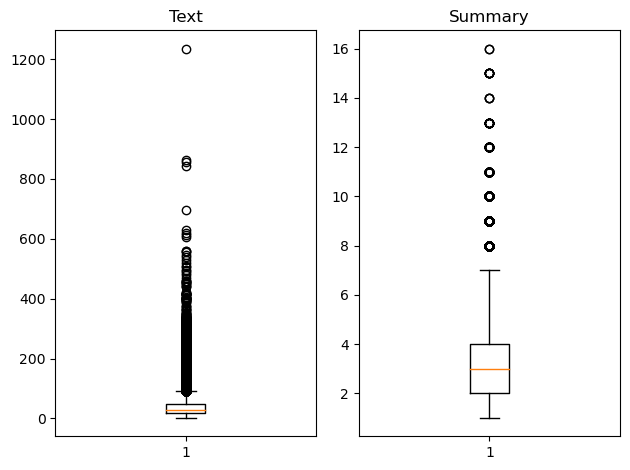

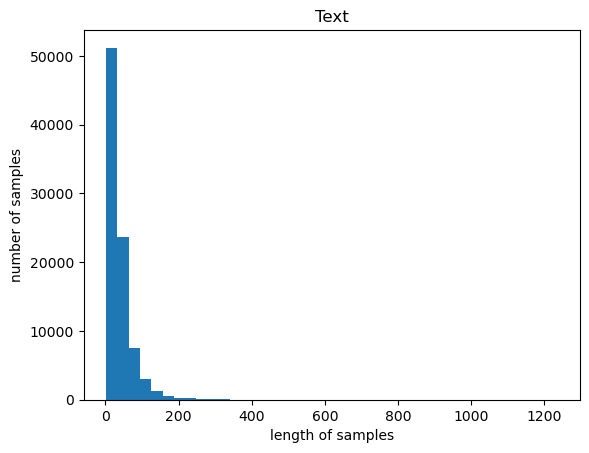

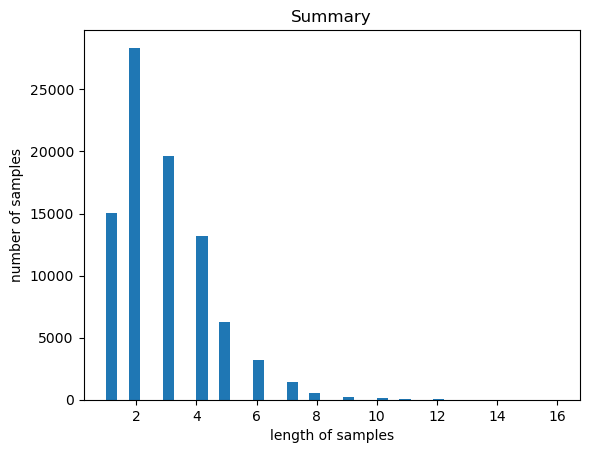

In [21]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
text_max_len = 50
summary_max_len = 8
print('Complete!')

Complete!


In [23]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('Rate of samples length is under %s among all samples: %s'%(max_len, (cnt / len(nested_list))))
print('Complete!')

Complete!


In [24]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

Rate of samples length is under 50 among all samples: 0.7745478475957065
Rate of samples length is under 8 among all samples: 0.9944289377538748


In [25]:
data['Text'] = data['Text'].apply(lambda x: x if len(x.split()) <= text_max_len else '')
data['Summary'] = data['Summary'].apply(lambda x: x if len(x.split()) <= summary_max_len else '')

data = data.replace('', np.nan)
data.dropna(axis=0, inplace=True)

/var/folders/jd/wlq5yr_n4knc0k78z_jdh19m0000gn/T/ipykernel_49261/2431197741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Text'] = data['Text'].apply(lambda x: x if len(x.split()) <= text_max_len else '')
/var/folders/jd/wlq5yr_n4knc0k78z_jdh19m0000gn/T/ipykernel_49261/2431197741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Summary'] = data['Summary'].apply(lambda x: x if len(x.split()) <= summary_max_len else '')


In [26]:
print('텍스트의 최대 길이 : {}'.format(np.max([len(s.split()) for s in data['Text']])))

텍스트의 최대 길이 : 50


In [27]:
print('Number of samples in: ', (len(data)))

Number of samples in:  68052


In [28]:
data['decoder_input'] = data['Summary'].fillna('').apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].fillna('').apply(lambda x : x + ' eostoken')

data

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,advertised,sostoken advertised,advertised eostoken
2,confection around centuries light pillowy citr...,delight says,sostoken delight says,delight says eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken
...,...,...,...,...
99993,stuff awesome best flavor boil water drain wat...,great stuff,sostoken great stuff,great stuff eostoken
99994,love noodle little spicy wife perfct,good stuff,sostoken good stuff,good stuff eostoken
99995,love buy another box done last one,yummy,sostoken yummy,yummy eostoken
99997,favorite brand korean ramen spicy used eating ...,great ramen,sostoken great ramen,great ramen eostoken


In [29]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

print('Complete!')

Complete!


In [30]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[45206 19952 19905 ...  8061 67260 48156]


In [31]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [32]:
n_of_val = int(len(encoder_input)*0.2)
print('Number of validation data: ', n_of_val)

Number of validation data:  13610


In [33]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('Number of training data: ', len(encoder_input_train))
print('Number of training label: ', len(decoder_input_train))
print('Number of validation data: ', len(encoder_input_test))
print('Number of validation label: ', len(decoder_input_test))

Number of training data:  54442
Number of training label:  54442
Number of validation data:  13610
Number of validation label:  13610


In [36]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [37]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for  key, value in src_tokenizer.word_counts.items():
    total_freq += value
    
    if(value < threshold):
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32798
등장 빈도가 6번 이하인 희귀 단어의 수: 24365
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8433
단어 집합에서 희귀 단어의 비율: 74.28806634550888
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3251700680272114


In [39]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [42]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

AttributeError: 'int' object has no attribute 'lower'

In [43]:
print(encoder_input_train[:3])

[[309, 536, 1227, 2325, 902, 566, 2693, 4490, 500, 536, 309, 38, 144, 2041, 2041, 276, 1175, 5790, 24, 2489, 536, 309, 1100, 187, 2693, 282, 2041, 3548, 99, 110, 91, 309, 592, 133, 2, 141], [572, 632, 100, 464, 1278, 3611, 105, 164, 51, 132, 194, 428, 291, 1753, 97, 211, 542, 718, 1729, 641, 611, 289, 593, 292, 212, 22, 356, 108, 1058, 352, 3053, 7001], [24, 11, 575, 5226, 1839, 474, 351, 7856, 3, 5, 57, 2887, 5072, 1742, 251, 1139, 11, 547, 350, 3, 26, 537, 2490, 994, 232, 4491, 277, 11, 100]]


In [44]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [45]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10813
등장 빈도가 5번 이하인 희귀 단어의 수: 8398
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2415
단어 집합에서 희귀 단어의 비율: 77.66577268103208
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.07905639299258


In [46]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 230, 104, 113], [1, 253], [1, 73, 360], [1, 6, 53, 31, 597], [1, 4, 1982, 1542]]
target
decoder  [[230, 104, 113, 2], [253, 2], [73, 360, 2], [6, 53, 31, 597, 2], [4, 1982, 1542, 2]]


In [47]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1693
삭제할 테스트 데이터의 개수 : 463
훈련 데이터의 개수 : 52749
훈련 레이블의 개수 : 52749
테스트 데이터의 개수 : 13147
테스트 레이블의 개수 : 13147


In [48]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [49]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

In [50]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [51]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 128)              1024000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 50, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [52]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 128)              1024000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 50, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

In [53]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
                    batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50


W0000 00:00:1704376229.258293       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


207/207 [==============================] - ETA: 0s - loss: 2.1943

W0000 00:00:1704376419.636567       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


207/207 [==============================] - 210s 992ms/step - loss: 2.1943 - val_loss: 2.0093
Epoch 2/50
207/207 [==============================] - 277s 1s/step - loss: 1.9188 - val_loss: 1.8626
Epoch 3/50
207/207 [==============================] - 293s 1s/step - loss: 1.8225 - val_loss: 1.8105
Epoch 4/50
207/207 [==============================] - 272s 1s/step - loss: 1.7558 - val_loss: 1.7680
Epoch 5/50
207/207 [==============================] - 273s 1s/step - loss: 1.7121 - val_loss: 1.7354
Epoch 6/50
207/207 [==============================] - 266s 1s/step - loss: 1.6759 - val_loss: 1.7253
Epoch 7/50
207/207 [==============================] - 296s 1s/step - loss: 1.6400 - val_loss: 1.7308
Epoch 8/50
207/207 [==============================] - 235s 1s/step - loss: 1.6071 - val_loss: 1.6832
Epoch 9/50
207/207 [==============================] - 262s 1s/step - loss: 1.5764 - val_loss: 1.6716
Epoch 10/50
207/207 [==============================] - 265s 1s/step - loss: 1.5463 - val_loss: 1.65

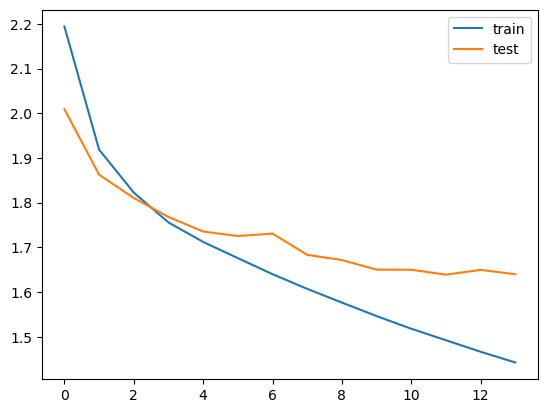

In [54]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [55]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [56]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [57]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [58]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [60]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if i == 0:
            continue
        if i == tar_word_to_index['eostoken']:
            break
        temp += tar_index_to_word[i] + ' '
    return temp

In [61]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : dog really enjoys daily treat however next physical really cannot properly try remember update physical report back tartar build reduced eliminated vet said work dog chews slowly dog goes pretty fast sure going effective decided give year see happens 
실제 요약 : sostoken fine know next 
1/1 [==============================] - 0s 9ms/step
예측 요약 :  dog loves


원문 : guys rock nice refreshing drink little extra kick help wind reorder thanks mood mind 
실제 요약 : sostoken nice refreshing relaxing 
1/1 [==============================] - ETA: 0s

W0000 00:00:1704380774.202233       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 0s 9ms/step
예측 요약 :  ginger ginger


원문 : bought montana gas station try believe best soda find locally save shipping would definitely give try looking locally also wisconsin real cherry sodas 
실제 요약 : sostoken pricey best cherry soda found 
1/1 [==============================] - 0s 9ms/step
예측 요약 :  best


원문 : presented quick ship thank cat loves crunchy ones much better teeth 
실제 요약 : sostoken quick ship thank 
1/1 [==============================] - 0s 9ms/step
예측 요약 :  cat loves


원문 : become hesitant giving american bulldog dental chews tends gulp two bites vet recommended oral hygiene chews dog chew properly ends gagging based good reviews decided try checkups far working great dog eager get treat chews slowly used many yet tell breath better looks like teeth improving upset sensitive stomach 
실제 요약 : sostoken dental treats 
1/1 [==============================] - 0s 10ms/step
예측 요약 :  great product


원문 : product information tell tea include

In [63]:
import requests
from summa.summarizer import summarize

ModuleNotFoundError: No module named 'summa'

In [ ]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text